# Data Exploration

This notebook demonstrates the data acquisition and preprocessing pipeline.

## Objectives:
1. Download market data for our asset universe
2. Explore data quality and characteristics
3. Visualize price series and distributions
4. Validate data preprocessing

**Note**: The bugs from yfinance multi-index columns have been fixed in the codebase!

In [4]:
# Setup
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.utils.config import ConfigLoader
from src.data.acquisition import DataAcquisition
from src.data.preprocessing import DataPreprocessor
from src.utils.visualizations import plot_price_series

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Load Configuration

In [5]:
# Load configs
config_loader = ConfigLoader('../config')
data_config = config_loader.load('data_config')

print("Asset Universe:")
print(f"  Timing Agent: {data_config['timing_agent']['ticker']}")
print(f"  Portfolio Agent: {data_config['portfolio_agent']['tickers']}")
print(f"\nDate Range: {data_config['start_date']} to {data_config['end_date']}")

INFO:src.utils.config:Loaded config: data_config


Asset Universe:
  Timing Agent: SPY
  Portfolio Agent: ['SPY', 'QQQ', 'GLD', 'TLT']

Date Range: 2000-01-01 to 2024-12-31


## 2. Download Data

We'll download data for all portfolio agent tickers. This may take a minute on first run, but subsequent runs will use cached data.

In [6]:
# Initialize data acquisition
data_acq = DataAcquisition(cache_dir='../data/raw')

# Download portfolio agent tickers
tickers = data_config['portfolio_agent']['tickers']

print(f"Downloading {len(tickers)} tickers: {tickers}")
print("This may take 1-2 minutes on first run...\n")

data = data_acq.download_multiple(
    tickers=tickers,
    start_date=data_config['start_date'],
    end_date=data_config['end_date'],
    use_cache=True
)

print(f"\n✓ Downloaded {len(data)} rows for {len(tickers)} tickers")
print(f"  Data shape: {data.shape}")
print(f"  Columns: {list(data.columns)}")
print(f"  Date range: {data.index.min()} to {data.index.max()}")

INFO:src.data.acquisition:Loading SPY from cache
INFO:src.data.acquisition:Loading QQQ from cache
INFO:src.data.acquisition:Loading GLD from cache
INFO:src.data.acquisition:Loading TLT from cache
INFO:src.data.acquisition:Downloaded 4 tickers, total 23282 rows


This may take 1-2 minutes on first run...


✓ Downloaded 23282 rows for 4 tickers
  Data shape: (23282, 6)
  Columns: ['close', 'high', 'low', 'open', 'volume', 'ticker']
  Date range: 2000-01-03 00:00:00 to 2024-12-30 00:00:00


## 3. Data Quality Check

In [7]:
# Check missing values by ticker
print("Missing Values by Ticker:")
for ticker in tickers:
    ticker_data = data[data['ticker'] == ticker]
    missing = ticker_data.isnull().sum().sum()
    print(f"  {ticker}: {missing} missing values ({len(ticker_data)} rows)")

# Summary statistics for first ticker
print(f"\nSummary Statistics for {tickers[0]}:")
spy_data = data[data['ticker'] == tickers[0]]
print(spy_data[['open', 'high', 'low', 'close', 'volume']].describe())

Missing Values by Ticker:
  SPY: 0 missing values (6288 rows)
  QQQ: 0 missing values (6288 rows)
  GLD: 0 missing values (5062 rows)
  TLT: 0 missing values (5644 rows)

Summary Statistics for SPY:
              open         high          low        close        volume
count  6288.000000  6288.000000  6288.000000  6288.000000  6.288000e+03
mean    180.293298   181.326180   179.165557   180.309211  1.061052e+08
std     130.608527   131.238553   129.915852   130.632877  9.098375e+07
min      49.974483    51.482178    49.349352    50.092159  1.436600e+06
25%      84.292896    84.770130    83.749667    84.239830  5.020322e+07
50%     110.043923   110.520014   109.599482   110.082382  7.888170e+07
75%     245.960923   246.931013   244.306549   245.954594  1.348241e+08
max     600.390725   601.754152   599.728788   600.509277  8.710263e+08


## 4. Visualize Price Series

Let's plot the closing prices for all tickers to see their behavior over time.

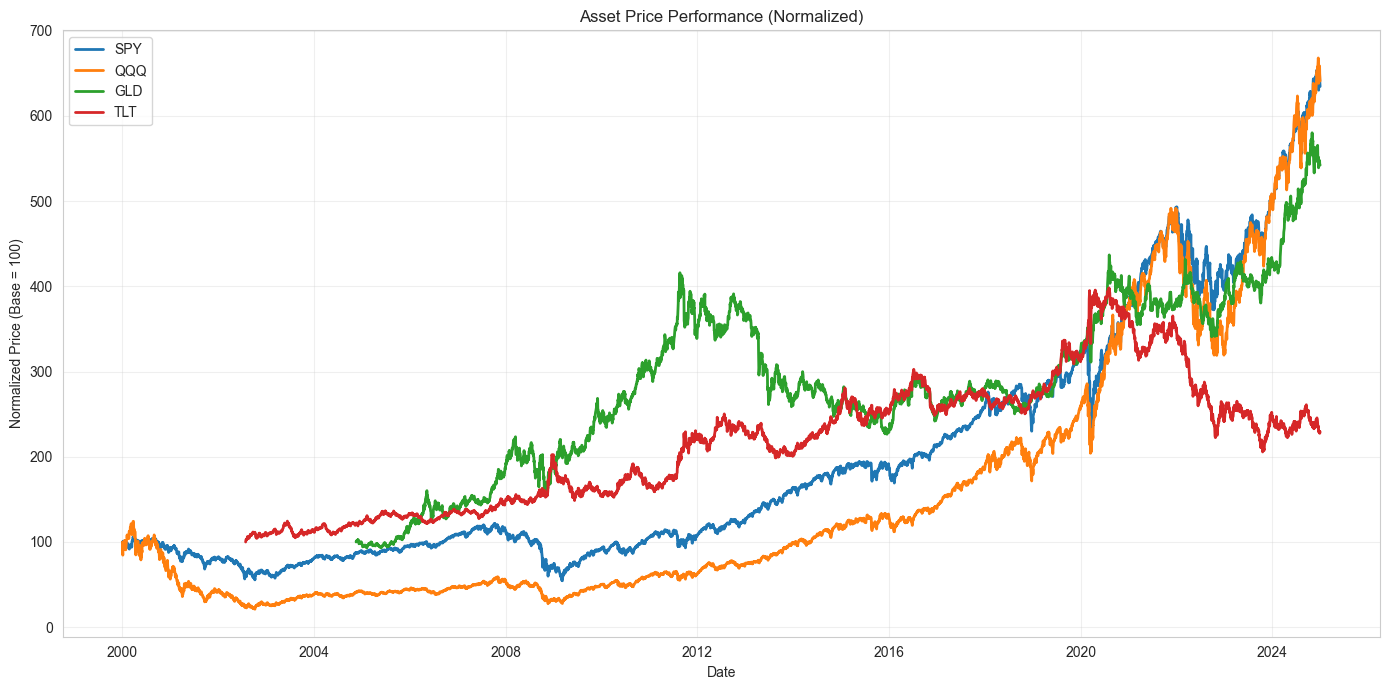


Relative Performance (Total Return):
  SPY: 534.6%
  QQQ: 541.0%
  GLD: 442.2%
  TLT: 129.4%


In [8]:
# Plot all tickers on one chart
fig, ax = plt.subplots(figsize=(14, 7))

for ticker in tickers:
    ticker_data = data[data['ticker'] == ticker]
    # Normalize to start at 100 for comparison
    normalized = ticker_data['close'] / ticker_data['close'].iloc[0] * 100
    ax.plot(ticker_data.index, normalized, label=ticker, linewidth=2)

ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (Base = 100)')
ax.set_title('Asset Price Performance (Normalized)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRelative Performance (Total Return):")
for ticker in tickers:
    ticker_data = data[data['ticker'] == ticker]
    total_return = (ticker_data['close'].iloc[-1] / ticker_data['close'].iloc[0] - 1) * 100
    print(f"  {ticker}: {total_return:.1f}%")

## 5. Volume Analysis

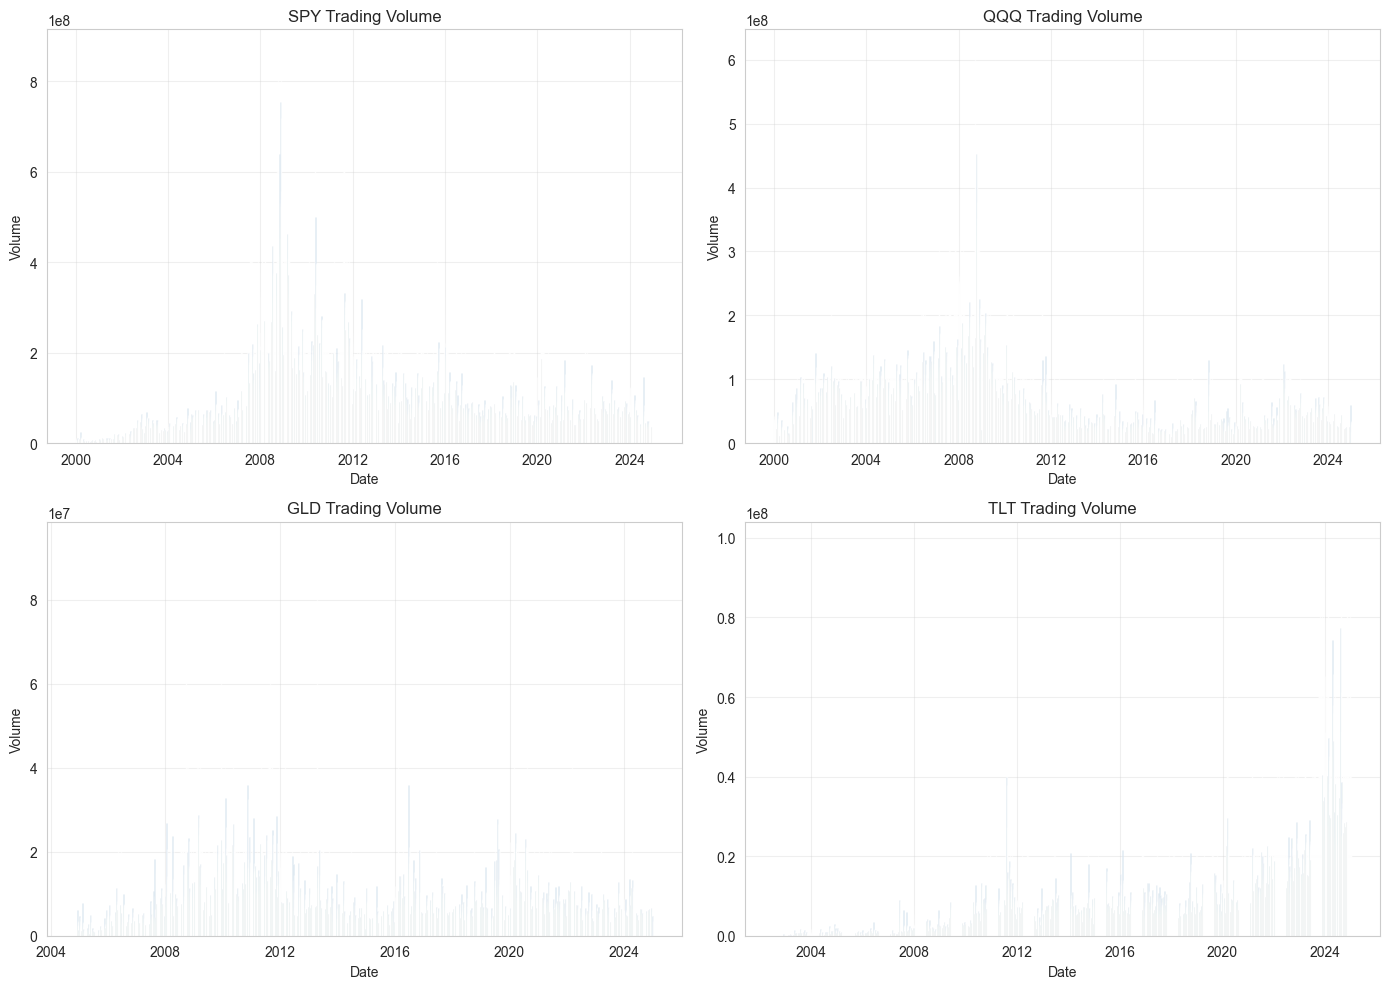

In [9]:
# Plot volume for each ticker
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    ticker_data = data[data['ticker'] == ticker]
    axes[idx].bar(ticker_data.index, ticker_data['volume'], alpha=0.5, color='steelblue')
    axes[idx].set_title(f'{ticker} Trading Volume')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Volume')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Returns Distribution

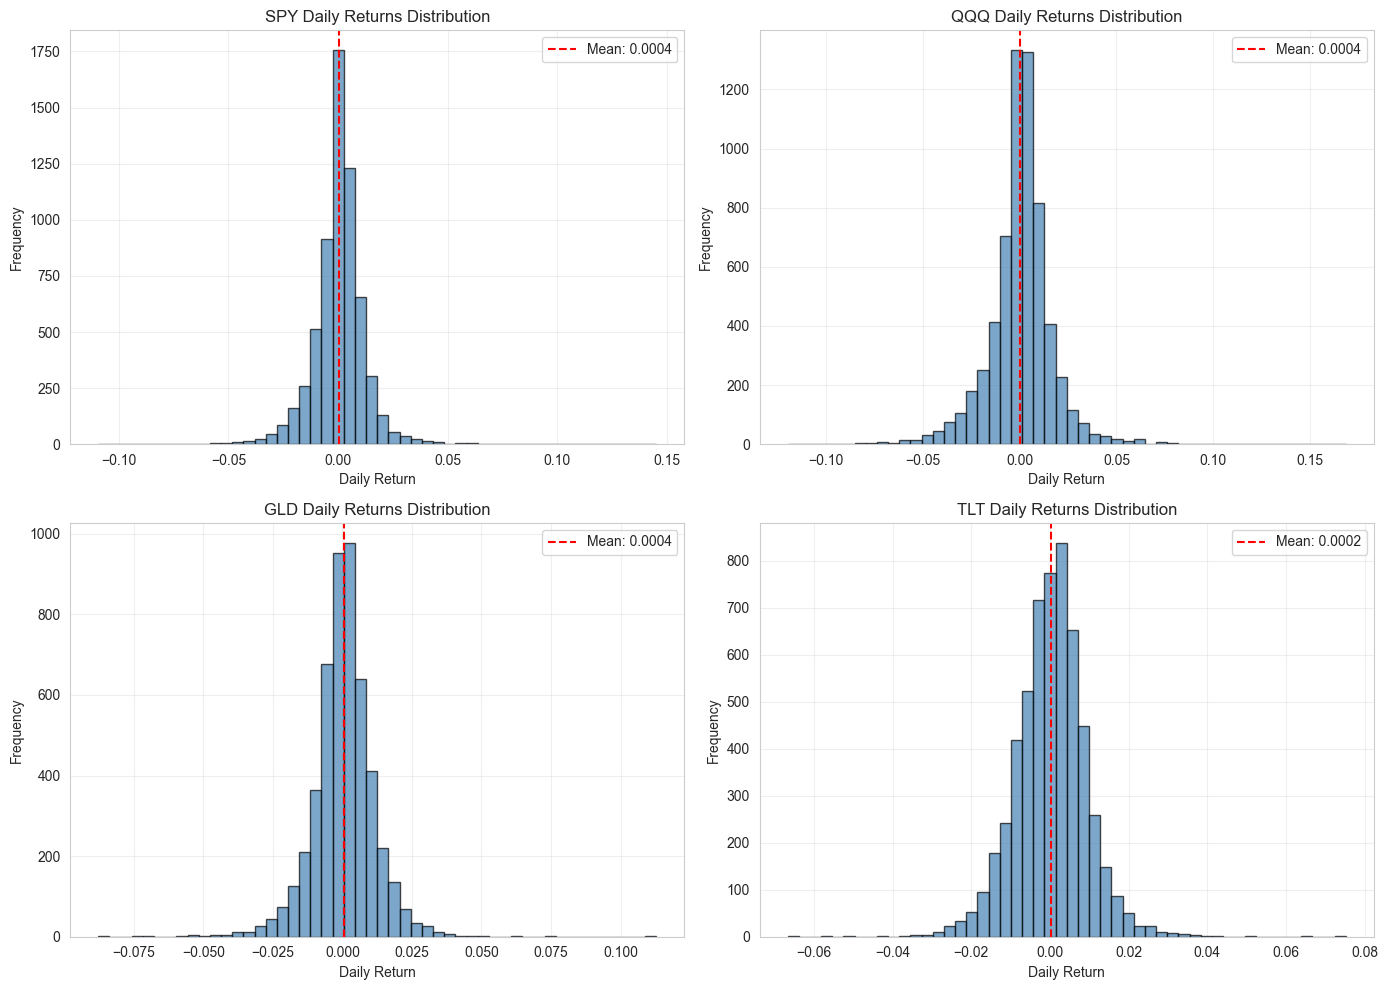


Daily Returns Statistics:

SPY:
  Mean: 0.0004
  Std: 0.0122
  Sharpe (annual): 0.48

QQQ:
  Mean: 0.0004
  Std: 0.0170
  Sharpe (annual): 0.41

GLD:
  Mean: 0.0004
  Std: 0.0110
  Sharpe (annual): 0.57

TLT:
  Mean: 0.0002
  Std: 0.0091
  Sharpe (annual): 0.33


In [10]:
# Calculate daily returns for each ticker
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    ticker_data = data[data['ticker'] == ticker]
    returns = ticker_data['close'].pct_change().dropna()
    
    axes[idx].hist(returns, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].axvline(returns.mean(), color='r', linestyle='--', label=f'Mean: {returns.mean():.4f}')
    axes[idx].set_title(f'{ticker} Daily Returns Distribution')
    axes[idx].set_xlabel('Daily Return')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nDaily Returns Statistics:")
for ticker in tickers:
    ticker_data = data[data['ticker'] == ticker]
    returns = ticker_data['close'].pct_change().dropna()
    print(f"\n{ticker}:")
    print(f"  Mean: {returns.mean():.4f}")
    print(f"  Std: {returns.std():.4f}")
    print(f"  Sharpe (annual): {returns.mean() / returns.std() * np.sqrt(252):.2f}")

## 7. Preprocess Data

Now let's clean and align the data across all tickers.

In [11]:
# Preprocess
print("Preprocessing data...")
preprocessor = DataPreprocessor(data_config)
clean_data = preprocessor.process(data)

print(f"\n✓ Preprocessing complete")
print(f"  Clean data shape: {clean_data.shape}")
print(f"  Missing values: {clean_data.isnull().sum().sum()}")

# Check how many dates we have for each ticker
print("\nRows per ticker after alignment:")
for ticker in tickers:
    ticker_data = clean_data[clean_data['ticker'] == ticker]
    print(f"  {ticker}: {len(ticker_data)} rows")

INFO:src.data.preprocessing:Starting data preprocessing
INFO:src.data.preprocessing:Handled 0 missing values
INFO:src.data.preprocessing:Aligning dates across tickers
INFO:src.data.preprocessing:Aligning 4 tickers
INFO:src.data.preprocessing:Aligned to 5062 common dates across 4 tickers
INFO:src.data.preprocessing:Data validation passed
INFO:src.data.preprocessing:Preprocessing complete: 20248 rows


Preprocessing data...

✓ Preprocessing complete
  Clean data shape: (20248, 6)
  Missing values: 0

Rows per ticker after alignment:
  SPY: 5062 rows
  QQQ: 5062 rows
  GLD: 5062 rows
  TLT: 5062 rows


## 8. Save Processed Data

In [12]:
# Save to parquet
output_path = '../data/processed/market_data.parquet'
clean_data.to_parquet(output_path)
print(f"✓ Saved processed data to {output_path}")
print(f"  File size: {clean_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Saved processed data to ../data/processed/market_data.parquet
  File size: 2.09 MB


## Summary

In this notebook, we:
1. ✓ Downloaded OHLCV data for SPY, QQQ, GLD, TLT from 2000-present
2. ✓ Explored data quality and characteristics
3. ✓ Visualized price performance and returns distributions
4. ✓ Preprocessed and aligned data across all tickers
5. ✓ Saved clean data for feature engineering

**Next Step**: Open `02_feature_analysis.ipynb` to engineer technical indicators!